# Проект исследования оттока клиентов сети фитнес-центров

## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.
А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1) выделить целевые группы клиентов;
    2) предложить меры по снижению оттока;
    3) определить другие особенности взаимодействия с клиентами.

## Описание данных

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент (в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

## Импорт библиотек и данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

import os

In [2]:
pth1 = 'D:\Yandex_Practikum\ML\gym_churn.csv'
pth2 = '/datasets/gym_churn.csv'

if os.path.exists(pth1):
    gym = pd.read_csv(pth1, sep=',')
elif os.path.exists(pth2):
    gym = pd.read_csv(pth2, sep=',')
else:
    print('Something is wrong')
          
display(gym.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Предобработка данных

In [3]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
gym.columns = gym.columns.str.lower() # приведем названия столбцов к единому регистру

In [5]:
print(gym.isna().sum())
print(gym.duplicated().sum())
gym.describe()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64
0


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


<div class="alert alert-info">
    
Типы данных в нужном формате. Пропуски и дубликаты отсутствуют.
- доли мужчин и женщин среди клиентов примерно одинаковы
- большинство клиентов проживают в непосредственной близости от фитнес-центра
- почти половина являются корпоративными клиентами
- чуть менее трети пришли по программе "Приведи друга"
- средний срок абонемента составляет чуть менее 5 месяцев, т.е. преобладает доля краткосрочных абонементов
- более одной трети посещают групповые занятия
- средний возраст клиентов 29 лет, в основном +-3 года
- средняя выручка на клиента 146 тысяч, с базой распределения от 50 до 240 тысяч
- средняя длительность посещения и срок до окончания абонемента фитнес-центра около 4 месяцев, с примерно таким же стандартным отклонением. Это значит основная доля абонементов на 1 и 6 месяцев
- в неделю центр посещают в среднем около 2 раз, в основе от 1 до 3 посещений
- доля оттока в среднем около 26%
    
</div>

## Проведем исследовательский анализ данных

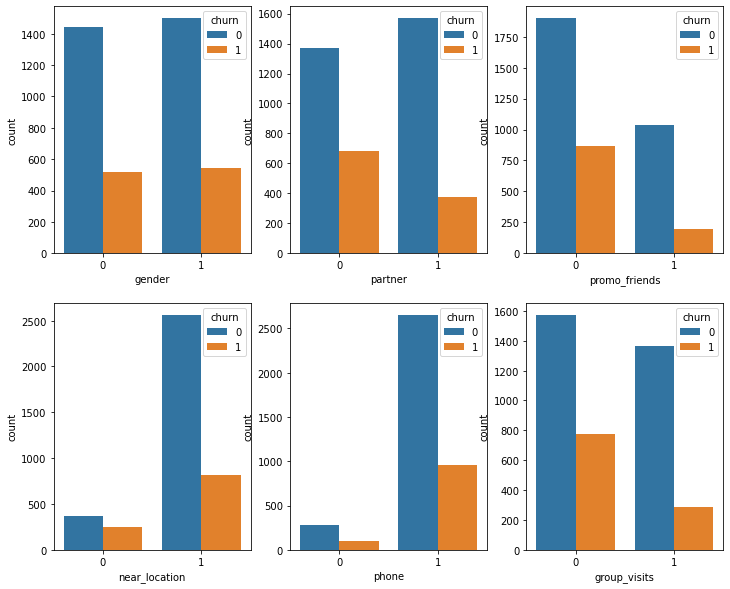

In [6]:
# посмотрим распределения категориальных признаков с разбивкой по оттоку

fig, axs = plt.subplots(2, 3, figsize=(12, 10))
plt.subplot(2, 3, 1)
sns.countplot(x='gender', data=gym, hue='churn')
plt.subplot(2, 3, 2)
sns.countplot(x='partner', data=gym, hue='churn')
plt.subplot(2, 3, 3)
sns.countplot(x='promo_friends', data=gym, hue='churn')
plt.subplot(2, 3, 4)
sns.countplot(x='near_location', data=gym, hue='churn')
plt.subplot(2, 3, 5)
sns.countplot(x='phone', data=gym, hue='churn')
plt.subplot(2, 3, 6)
sns.countplot(x='group_visits', data=gym, hue='churn')
plt.show()

<div class="alert alert-info">

#### Показатели категориальных признаков для клиентов с разбивкой по оттоку:
- доли мужчин и женщин в обоих сегментах примерно одинаковы
- клиентов проживающих в непосредственной близости от фитнес-центра почти в 4 раза больше, чем остальных. Возможно близость центра к дому слабо коррелирует с оттоком
- в сегменте оттока некорпоративных клиентов в 2 раза больше
- клиенты, которые пришли по приглашению "Приведи друга", примерно в 3 раза реже попадают в отток.
- более чем в 2 раза реже попадают в отток, клиенты посещающие групповые занятия 
- основу возрастного распределения составляют клиенты от 22 до 31 года
    
</div>

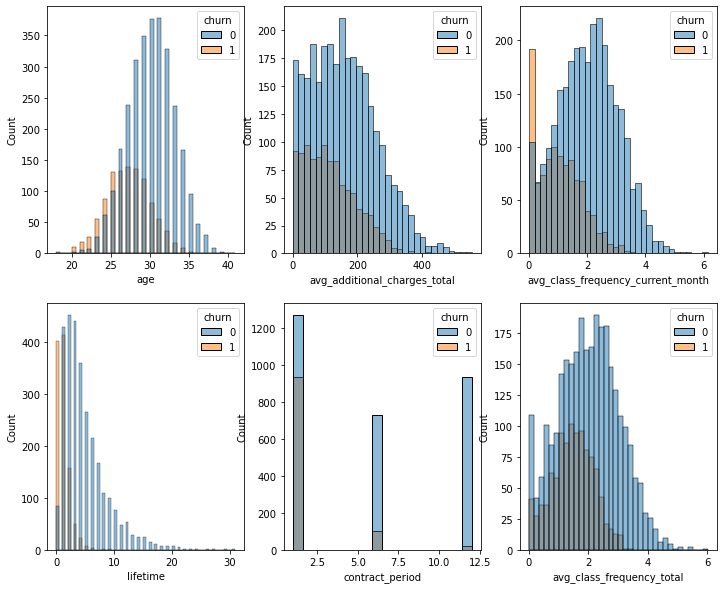

In [7]:
# посмотрим распределения числовых признаков с разбивкой по оттоку

fig, axs = plt.subplots(2, 3, figsize=(12, 10))
plt.subplot(2, 3, 1)
sns.histplot(x='age', data=gym, hue='churn')
plt.subplot(2, 3, 2)
sns.histplot(x='avg_additional_charges_total', data=gym, hue='churn')
plt.subplot(2, 3, 3)
sns.histplot(x='avg_class_frequency_current_month', data=gym, hue='churn')
plt.subplot(2, 3, 4)
sns.histplot(x='lifetime', data=gym, hue='churn')
plt.subplot(2, 3, 5)
sns.histplot(x='contract_period', data=gym, hue='churn')
plt.subplot(2, 3, 6)
sns.histplot(x='avg_class_frequency_total', data=gym, hue='churn')
plt.show()

<div class="alert alert-info">

#### Показатели числовых признаков для клиентов с разбивкой по оттоку:
- доля клиентов в сегменте оттока в основном имеют контракт на 1 месяц. Клиенты с годовым абонементом практически не попадают в отток
- в сегмент с оттоком в основном попадают менее возрастные клиенты, границы распределения от 20 до 34 лет
- по общей выручке постоянные клиенты тратят в 2 раза больше. В диапазоне от 300 тысяч практически не склонны к оттоку
- те кто посещает центр более 6 месяцев почти не склонны к оттоку. Максимальные показатели оттока в первые 3 месяца посещений клиента.
- распределение количества посещений клиентов в сегменте оттока от 0 до 3 занятий в неделю, кто занимается чаще практически всегда становится постоянным
- показатель среднего количества посещений в неделю за последний месяц схож с предыдущим, при этом максимальная доля в оттоке тех, кто не посещает центр за этот месяц вовсе.
    
</div>

In [8]:
(gym.groupby('churn').mean()).round(2).T # средние значения показателей с разбиением по признаку "отток"

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


<div class="alert alert-info">

#### Средние показатели признаков для клиентов с разбивкой по признаку "отток":
- доли мужчин и женщин также примерно одинаковы
- клиентов проживающих в непосредственной близости от фитнес-центра в сегменте без оттока на 10% больше.
- в сегменте без оттока доля корпоративных клиентов 53%, в сегменте оттока - 36%
- по приглашению "Приведи друга" среди постоянных клиентов пришли 35%. У сегмента отток - 18%
- среди клиентов без оттока в среднем контракт от 6 месяцев
- постоянные клиенты примерно в равной степени посещают как индивидуальные, так и групповые занятия. Однако у постоянных клиентов посещаемость на 20% больше 
- постоянные клиенты в среднем на 3 года старше, и по общей выручке тратят на 50 тысяч больше
- также признак постоянства среднее количество тренировок от 2 в неделю и за последний месяц, если ниже - скорее всего отток
    
</div>

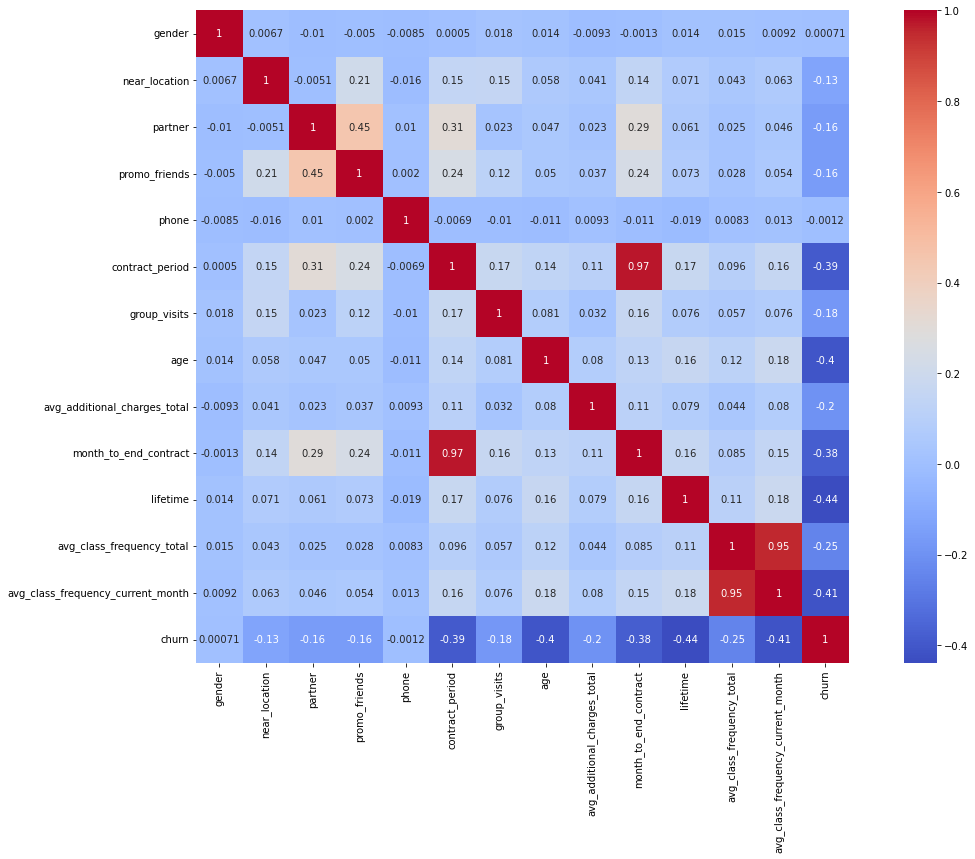

In [9]:
# построим матрицу корреляции признаков

cm = gym.corr()
fig, ax = plt.subplots()

sns.heatmap(cm, annot = True, square=True, cmap='coolwarm')
ax.set_ylim(
    14, 0
)
plt.gcf().set_size_inches(20, 12)
plt.show()

<div class="alert alert-info">

- на отток практически не влияют признаки "phone" и "gender"
- признаки в умеренной степени влияющие на отток: 
    - среднее количество посещений в неделю за последний месяц, 
    - период с первого посещения, 
    - возраст, 
    - количество месяцев до завершения контракта, 
    - срок контракта
- признаки в слабой степени влияющие на отток: 
    - среднее количество посещений в неделю за все время, 
    - близость расположения, 
    - статус корпоративного клиента, 
    - пришедший по программе "Пригласи друга", 
    - сумма выручки от клиента за весь период
    
- сильно коррелируют между собой признаки "month_to_end_contract" и "contract_period"(97%), "avg_class_frequency_total" и "avg_class_frequency_current_month"(95%). Удалим перед построением моделей по одному признаку у каждой пары, чтобы они не влияли на качество обучения модели(мультиколлинеарность негативно влияет на модель, при наличии последней модель старается подогнать алгоритм под определенные результаты, что нивелирует способность модели развиваться)
- коэффициент корреляции Пирсона выявляет прямые и косвенные линейные зависимости показателей, где от изменения одного меняется значение другого, и обратно
- утверждать об отсутствии связи при близких к нулю показателях корреляции тоже нельзя, т.к. этот показатель может значительно коррелировать с другим показателем, который в свою очередь влияет на целевой.
- утверждать о причинно-следственной связях при высоких значениях корреляции можно, но при этом нужно учитывать, что на следствие влияет несколько причин-факторов в различной степени влияния
    
</div>

In [10]:
# удалим сильно коррелирующие признаки

gym_corr = gym.drop(['contract_period', 'avg_class_frequency_total'], axis=1)

## Построим модели прогнозирования оттока клиентов

In [11]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_corr.drop('churn', axis=1)
y = gym_corr['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [12]:
# зададим алгоритм "логистическая регрессия" для нашей модели
model = LogisticRegression(solver='liblinear', random_state=0)

# обучим модель
model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
probabilities = model.predict_proba(X_test)[:, 1]

# бинарный прогноз
predictions = model.predict(X_test)

# выводим все изученные метрики для полученного прогноза
print('Метрики для модели логистической регрессии:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

Метрики для модели логистической регрессии:
Accuracy: 0.90
Precision: 0.80
Recall: 0.79
F1: 0.79
ROC_AUC: 0.96


In [13]:
# зададим алгоритм "случайный лес" для нашей модели
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)

# обучим модель
rf_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

# бинарный прогноз
rf_predictions = rf_model.predict(X_test)

# выводим все изученные метрики для полученного прогноза
print('Метрики для модели случайного леса:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities)))

Метрики для модели случайного леса:
Accuracy: 0.91
Precision: 0.83
Recall: 0.79
F1: 0.81
ROC_AUC: 0.95


<div class="alert alert-info">
    
- accuracy работает при условии баланса классов — когда объектов каждого класса примерно поровну, 50% на 50%, в нашем датасете дисбалансы практически по всем классам, единственное можно выделить гендерное соотношение
- с точки зрения данного бизнеса нам более важна метрика recall, чтобы выявить всех клиентов склонных к оттоку и проработать их, плюс здесь ложноположительное срабатывание на принадлежность к оттоку не столь затратно по ресурсам
- если известны убытки в случае ухода клиента и известны расходы связанные с попыткой удержать клиента от ухода, и при наших recall и precision оказывается что расходы на удержание клиентов гораздо ниже чем прибыль от того, что некоторых клиентов удалось удержать. То необходимо применять метрику F1_score для выявления балансов recall и precision, чем ближе к "1", тем лучше. А затем с помощью метрики ROC_AUC или "площадь под кривой ошибок" которая оценивает вероятность  того, что наблюдение принадлежит к классу "0" или "1".
    
<div>

#### Алгоритм случайного леса работает лучше. Посмотрим важность признаков "по весу"

In [14]:
importances = pd.DataFrame(rf_model.feature_importances_)
print(importances.sort_values(by=0, ascending=False))

           0
9   0.321614
10  0.209702
6   0.139873
7   0.124591
8   0.116619
5   0.019822
3   0.016033
2   0.015954
0   0.015723
1   0.011902
4   0.008165


<div class="alert alert-info">
    
#### Наиболее важными признаками являются 
- среднее количество посещений за последний месяц
- общий срок с первого посещения
    
<div>

## Кластеризация клиентов

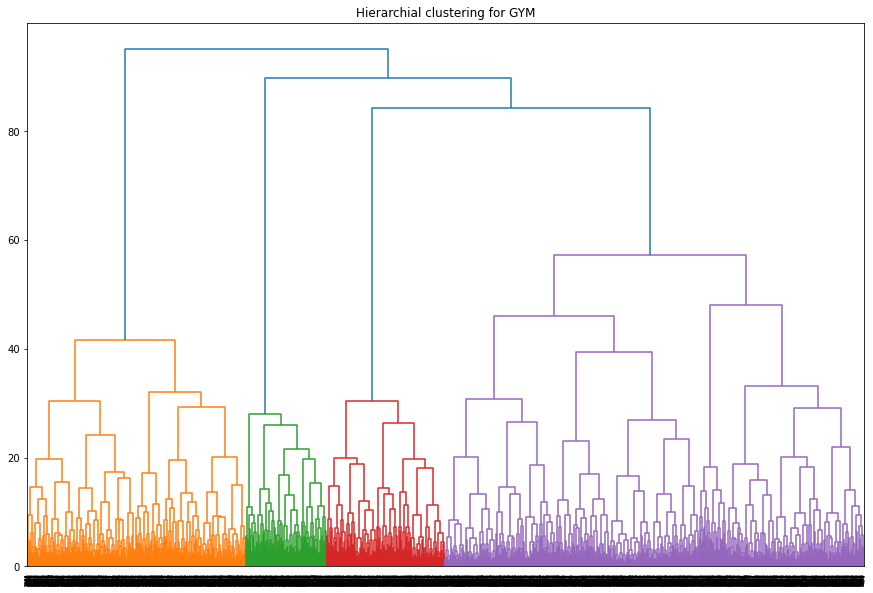

In [15]:
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
X_sc = scaler.fit_transform(gym_corr.drop(columns = ['churn'])) # обучаем нормализатор и преобразуем набор данных 

linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

#### По дендрограмме видим что можно выделить 3-6 кластеров. Потестируем с помощью алгоритма K-Means на количество кластеров

In [16]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(gym_corr)

# задаём модель k_means с числом кластеров 3 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
gym_corr['clusters'] = labels

In [17]:
cluster_features = gym_corr.groupby('clusters').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['clusters']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

,clusters,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
0,0,0.52,1.00,0.34,0.22,1.00,0.29,26.91,114.21,1.68,0.98,1.05,0.99
1,1,0.49,0.99,0.95,0.74,1.00,0.51,29.91,159.69,7.69,4.59,2.01,0.01
2,2,0.52,1.00,0.15,0.07,1.00,0.47,30.07,160.26,3.44,4.85,2.07,0.00
3,3,0.52,0.86,0.47,0.31,0.00,0.43,29.30,144.21,4.47,3.94,1.72,0.27
4,4,0.50,0.00,0.49,0.07,1.00,0.24,28.69,137.24,2.81,2.99,1.59,0.40


In [18]:
cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

C:\Users\Admin\AppData\Local\Temp\ipykernel_7072\793093793.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)


,0,1,2,3,4
clusters,0.00,1.00,2.00,3.00,4.00
gender,0.52,0.49,0.52,0.52,0.50
near_location,1.00,0.99,1.00,0.86,0.00
partner,0.34,0.95,0.15,0.47,0.49
promo_friends,0.22,0.74,0.07,0.31,0.07
phone,1.00,1.00,1.00,0.00,1.00
group_visits,0.29,0.51,0.47,0.43,0.24
age,26.91,29.91,30.07,29.30,28.69
avg_additional_charges_total,114.21,159.69,160.26,144.21,137.24
month_to_end_contract,1.68,7.69,3.44,4.47,2.81


<div class="alert alert-info">
    
Средние показатели по кластерам:
- гендерное соотношение у всех примерно одинаковое
- всех кроме 4 кластера можно отнести к местным
- в 1 кластере 95% клиентов корпоративные, в 3 и 4 кластерах доля корпоративных около 50%. Понятно почему 4 кластер не местных ездят далеко, наверняка это ближайший центр, который можно посещать по корпоративной программе
- 1 кластер имеет 74% клиентов приглашенных друзьями, 22% у 0 кластера и 31% у 3 кластера, у остальных почти нет приглашенных друзьями
- отсутствием контактных данных отличился 3 кластер
- групповые занятия посещают более-менее 1, 2 и 3 кластеры(40-50%). У 0 и 4 посещаемость менее 30%
- 0 кластер имеет наименее возрастную группу, в среднем 26 лет, остальные в среднем около 30
- больше всех тратят 1 и 2 кластеры, 3 и 4 чуть меньше, а меньше всех 0 кластер
- средний срок посещений с первого занятия у 1 и 2 кластера около 5 месяцев, 3 и 4 - 3-4 мес. У 0 наименьший - в среднем 1 мес.
- 1 и 2 кластеры в среднем посещают 2 раза в неделю за последний месяц, 3 и 4 - от 1.5 до 1.7 занятий, у 0 кластера максимум 1 посещение.
- 1 и 2 кластеры практически не склонны к оттоку, 3 кластер с вероятностью 27%, 4 кластер - 40%. А 0 с вероятностью 99%
    
<div>

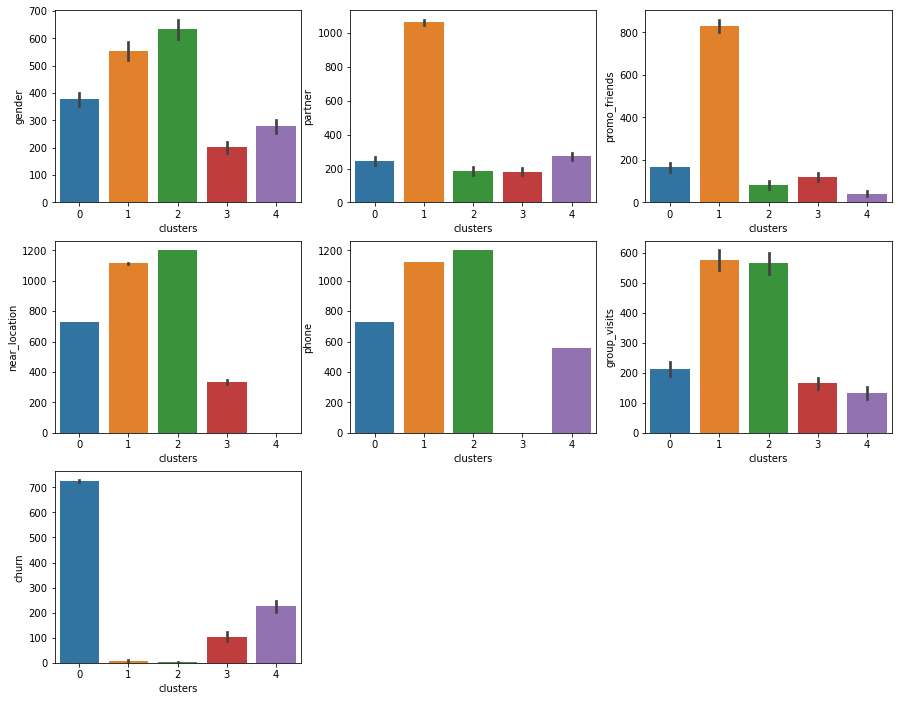

In [19]:
# посмотрим распределения категориальных признаков с разбивкой по кластерам

fig, axs = plt.subplots(2, 3, figsize=(15, 12))
plt.subplot(3, 3, 1)
sns.barplot(data=gym_corr, x='clusters', y='gender', estimator=np.sum)
plt.subplot(3, 3, 2)
sns.barplot(data=gym_corr, x='clusters', y='partner', estimator=np.sum)
plt.subplot(3, 3, 3)
sns.barplot(data=gym_corr, x='clusters', y='promo_friends', estimator=np.sum)
plt.subplot(3, 3, 4)
sns.barplot(data=gym_corr, x='clusters', y='near_location', estimator=np.sum)
plt.subplot(3, 3, 5)
sns.barplot(data=gym_corr, x='clusters', y='phone', estimator=np.sum)
plt.subplot(3, 3, 6)
sns.barplot(data=gym_corr, x='clusters', y='group_visits', estimator=np.sum)
plt.subplot(3, 3, 7)
sns.barplot(data=gym_corr, x='clusters', y='churn', estimator=np.sum)
plt.show()

<div class="alert alert-info">
    
Кластеры:
- в 1 кластере примерно в 5 раз больше корпоративных клиентов и приглашенных по программе "Пригласи друга", остальные кластеры имеют относительно малые значения и примерно одинаковые по данным признакам
- в 1 и 2 кластерах наибольшая доля проживающих поблизости, более полные контактные данные, почти в 3 раза больше посещают групповые занятия, а главное практически не склонны к оттоку
- в 0 кластере довольно много проживающих поблизости, в 3 в два раза меньше, а в 4 практически отсутствуют
- в 3 кластере почти никто не указал контактные данные
- посещаемость групповых занятий примерно одинакова у 0, 3 и 4 кластеров
- 0 кластер наиболее склонен к оттоку, хоть и проживает поблизости. 3 и 4 кластеры хоть и в разы, но также склонны к оттоку(проживают в основном далеко, меньше посещают групповые занятия и приходят по приглашению друзей)
    
<div>

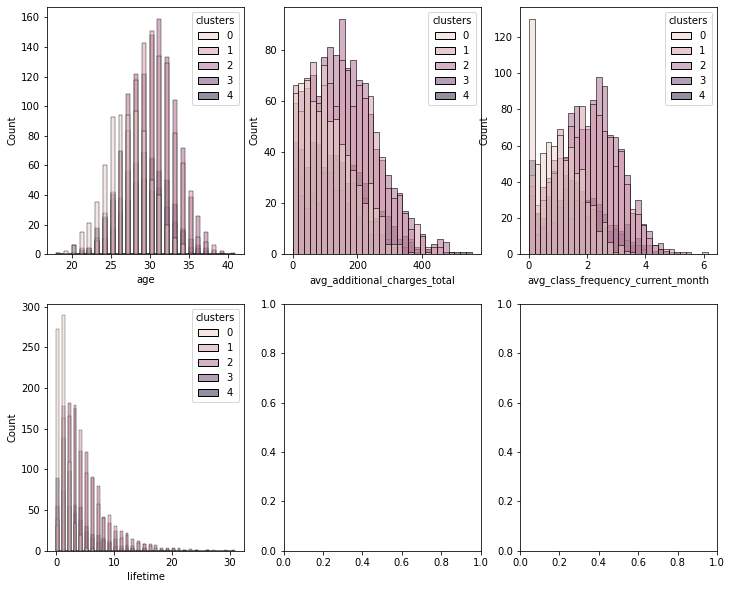

In [21]:
# посмотрим распределения числовых признаков с разбивкой по кластерам

fig, axs = plt.subplots(2, 3, figsize=(12, 10))
plt.subplot(2, 3, 1)
sns.histplot(x='age', data=gym_corr, hue='clusters')
plt.subplot(2, 3, 2)
sns.histplot(x='avg_additional_charges_total', data=gym_corr, hue='clusters')
plt.subplot(2, 3, 3)
sns.histplot(x='avg_class_frequency_current_month', data=gym_corr, hue='clusters')
plt.subplot(2, 3, 4)
sns.histplot(x='lifetime', data=gym_corr, hue='clusters')
plt.show()

<div class="alert alert-info">
    
- 1, 2 и 3 кластеры наиболее возрастные, причем доля в 1 и 2 кластерах в разы больше. Т.е. менее возрастные клиенты больше склонны к оттоку
- 1 и 2 кластеры тратят больше остальных и практически не склонны к оттоку.
- в 0 кластере клиенты посещают центр меньше остальных, не более 6 месяцев. Этот же кластер имеет наибольшую долю оттока
- 1 и 2 кластеры в среднем посещают больше занятий в неделю за последний месяц, 0 кластер с большой долей среднего количества посещений менее 2 или вообще не посещающих за последний месяц

#### Итог: 
- 0 кластер имеет наибольший отток, 
- 1 и 2 можно отнести к постоянным клиентам, 
- 3 к местным со слабой склонностью к оттоку
- 4 к не местным клиентам со средней вероятностью оттока
    
<div>

## Общие выводы и рекомендации

###### Предобработка и ход исследования:
- Были подготовлены и проанализированы данные о клиентах фитнес-центра. Качество данных отличное, отсутствуют пропуски и дубликаты, типы данных в порядке. 
- В процессе анализа рассмотрели значения признаков с разбивкой по сегменту "отток(1)\не отток(0)", выявили часть признаков, указывающих на склонность клиентов к оттоку. Разбили датасет на обучающую и тестовую выборки, обучили модели "Логистическая регрессия" и "Случайный лес". По метрикам более точна модель "случайного леса". Затем выделили 5 кластеров с помощью алгоритма K-Means
    
###### Общие выводы:
- на отток практически не влияют признаки "phone" и "gender"
- признаки в умеренной степени влияющие на отток: 
    - среднее количество посещений в неделю за последний месяц, 
    - период с первого посещения, 
    - возраст, 
    - количество месяцев до завершения контракта, 
    - срок контракта
- признаки в слабой степени влияющие на отток: 
    - среднее количество посещений в неделю за все время, 
    - близость расположения, 
    - статус корпоративного клиента, 
    - пришедший по программе "Пригласи друга", 
    - сумма выручки от клиента за весь период

###### Показатели категориальных признаков для клиентов с разбивкой по оттоку:
- доли мужчин и женщин в обоих сегментах примерно одинаковы
- клиентов проживающих в непосредственной близости от фитнес-центра почти в 4 раза больше, чем остальных. Возможно близость центра к дому слабо коррелирует с оттоком
- в сегменте оттока некорпоративных клиентов в 2 раза больше
- клиенты, которые пришли по приглашению "Приведи друга", примерно в 3 раза реже попадают в отток.
- более чем в 2 раза реже попадают в отток, клиенты посещающие групповые занятия 
- основу возрастного распределения составляют клиенты от 22 до 31 года

###### Показатели числовых признаков для клиентов с разбивкой по оттоку:
- доля клиентов в сегменте оттока в основном имеют контракт на 1 месяц. Клиенты с годовым абонементом практически не попадают в отток
- в сегмент с оттоком в основном попадают менее возрастные клиенты, границы распределения от 20 до 34 лет
- по общей выручке постоянные клиенты тратят в 2 раза больше. В диапазоне от 300 тысяч практически не склонны к оттоку
- те кто посещает центр более 6 месяцев почти не склонны к оттоку. Максимальные показатели оттока в первые 3 месяца посещений клиента.
- распределение количества посещений клиентов в сегменте оттока от 0 до 3 занятий в неделю, кто занимается чаще практически всегда становится постоянным
- показатель среднего количества посещений в неделю за последний месяц схож с предыдущим, при этом максимальная доля в оттоке тех, кто не посещает центр за этот месяц вовсе.

###### Средние показатели признаков для клиентов с разбивкой по признаку "отток":
- доли мужчин и женщин также примерно одинаковы
- клиентов проживающих в непосредственной близости от фитнес-центра в сегменте без оттока на 10% больше.
- в сегменте без оттока доля корпоративных клиентов 53%, в сегменте оттока - 36%
- по приглашению "Приведи друга" среди постоянных клиентов пришли 35%. У сегмента отток - 18%
- среди клиентов без оттока в среднем контракт от 6 месяцев
- постоянные клиенты примерно в равной степени посещают как индивидуальные, так и групповые занятия. Однако у постоянных клиентов посещаемость на 20% больше 
- постоянные клиенты в среднем на 3 года старше, и по общей выручке тратят на 50 тысяч больше
- также признак постоянства среднее количество тренировок от 2 в неделю и за последний месяц, если ниже - скорее всего отток

###### Результаты разбивки по кластерам:
- гендерное соотношение у всех примерно одинаковое
- всех кроме 4 кластера можно отнести к местным
- в 1 кластере 95% клиентов корпоративные, в 3 и 4 кластерах доля корпоративных около 50%. Понятно почему 4 кластер не местных ездят далеко, наверняка это ближайший центр, который можно посещать по корпоративной программе
- 1 кластер имеет 74% клиентов приглашенных друзьями, 22% у 0 кластера и 31% у 3 кластера, у остальных почти нет приглашенных друзьями
- отсутствием контактных данных отличился 3 кластер
- групповые занятия посещают более-менее 1, 2 и 3 кластеры(40-50%). У 0 и 4 посещаемость менее 30%
- 0 кластер имеет наименее возрастную группу, в среднем 26 лет, остальные в среднем около 30
- больше всех тратят 1 и 2 кластеры, 3 и 4 чуть меньше, а меньше всех 0 кластер
- средний срок посещений с первого занятия у 1 и 2 кластера около 5 месяцев, 3 и 4 - 3-4 мес. У 0 наименьший - в среднем 1 мес.
- 1 и 2 кластеры в среднем посещают 2 раза в неделю за последний месяц, 3 и 4 - от 1.5 до 1.7 занятий, у 0 кластера максимум 1 посещение.
- 1 и 2 кластеры практически не склонны к оттоку, 3 кластер с вероятностью 27%, 4 кластер - 40%. А 0 с вероятностью 99%
    
    Таким образом можно поделить клиентов на 5 кластеров:
    - 0 кластер имеет наибольший отток, 
    - 1 и 2 можно отнести к постоянным клиентам, 
    - 3 к местным со слабой склонностью к оттоку
    - 4 к не местным клиентам со средней вероятностью оттока

#### Рекомендации:
- привлекать более возрастную категорию клиентов, и проработать причины склонности к оттоку менее возрастных клиентов путем опроса о причинах прекращения занятий
- отслеживать посещаемость клиентов и при снижении в последний месяц предлагать дополнительные "плюшки", услуги или скидки для удержания клиента
- разработать программу на первый год посещений для нового клиента, чтобы он в первый полгода не ушел в отток
- провести дополнительное исследование клиентов 0 кластера (оттока) и подобрать "триггеры" для их удержания и возвращения
- проработать отсутствие контактов у 3 кластера, также опросить о причинах ухода, т.к. вроде и местные и доля корпоративных много
- также проработать показатель доли приглашенных у 2 кластера постоянных клиентов и постараться приблизить к доле 1 кластера